## Topic Modeling: probabilistic LSA / Non-negative Matrix Factorization

### Imports

In [36]:
import warnings
from collections import OrderedDict
from pathlib import Path
from random import randint
import numpy as np
import pandas as pd

# Visualization
from ipywidgets import interact, FloatSlider
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

# gensim for alternative models
from gensim.models import LdaModel, LdaMulticore
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus

In [2]:
% matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14.0, 8.7)
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

## Load BBC data

In [12]:
path = Path('bbc')
files = path.glob('**/*.txt')
doc_list = []
for i, file in enumerate(files):
    with file.open(encoding='latin1') as f:
        _, topic, file_name = file.parts

        lines = f.readlines()
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic.capitalize(), heading, body])

### Convert to DataFrame

In [13]:
docs = pd.DataFrame(doc_list, columns=['Category', 'Heading', 'Article'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
Category    2225 non-null object
Heading     2225 non-null object
Article     2225 non-null object
dtypes: object(3)
memory usage: 52.2+ KB


## Create Train & Test Sets

In [14]:
train_docs, test_docs = train_test_split(docs, 
                                         stratify=docs.Category, 
                                         test_size=50, 
                                         random_state=42)

In [15]:
train_docs.shape, test_docs.shape

((2175, 3), (50, 3))

In [16]:
pd.Series(test_docs.Category).value_counts()

Sport            12
Business         11
Politics          9
Entertainment     9
Tech              9
Name: Category, dtype: int64

### Vectorize train & test sets

In [42]:
vectorizer = TfidfVectorizer(max_df=.2, 
                             min_df=.01, 
                             stop_words='english')

train_dtm = vectorizer.fit_transform(train_docs.Article)
words = vectorizer.get_feature_names()
train_dtm

<2175x2899 sparse matrix of type '<class 'numpy.float64'>'
	with 204945 stored elements in Compressed Sparse Row format>

In [43]:
test_dtm = vectorizer.transform(test_docs.Article)
test_dtm

<50x2899 sparse matrix of type '<class 'numpy.float64'>'
	with 4759 stored elements in Compressed Sparse Row format>

### Get token counts

In [56]:
train_token_count = train_dtm.sum(0).A.squeeze()
tokens = vectorizer.get_feature_names()
word_count = pd.Series(train_token_count, index=tokens).sort_values(ascending=False)
word_count.head(10)

film       41.54
game       36.39
best       36.15
labour     33.14
music      31.20
company    29.99
election   28.59
england    28.36
party      28.06
market     27.51
dtype: float64

## probabilistic Latent Semantic Analysis

### Implementation using Non-Negative Matrix Factorization

pLSI [has been shown](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.70.8839&rep=rep1&type=pdf) to be equivalent to Non-Negative Matrix Factorization with Kullback-Leibler Divergence objective.

In [44]:
n_components = 5
topic_labels = ['Topic {}'.format(i) for i in range(1, n_components+1)]

In [45]:
nmf = NMF(n_components=n_components, 
          random_state=42, 
          solver='mu',
          beta_loss='kullback-leibler', 
          max_iter=1000)
nmf.fit(train_dtm)

NMF(alpha=0.0, beta_loss='kullback-leibler', init=None, l1_ratio=0.0,
  max_iter=1000, n_components=5, random_state=42, shuffle=False,
  solver='mu', tol=0.0001, verbose=0)

In [46]:
nmf.reconstruction_err_

316.2609400385988

### Explore Topics

In [47]:
train_doc_topics = nmf.transform(train_dtm)
train_doc_topics.shape

(2175, 5)

In [48]:
i = randint(0, len(train_docs))
(train_docs.iloc[i, :2].append(pd.Series(train_doc_topics[i], 
                                         index=topic_labels)))

Category                         Politics
Heading     Final hunts held as ban looms
Topic 1                              0.04
Topic 2                              0.04
Topic 3                              0.01
Topic 4                              0.00
Topic 5                              0.03
dtype: object

In [50]:
train_result = pd.DataFrame(data=train_doc_topics,
                   columns=topic_labels,
                   index=train_docs.Category)

In [52]:
test_eval = pd.DataFrame(data=nmf.transform(test_dtm), 
                         columns=topic_labels,
                         index=test_docs.Category)

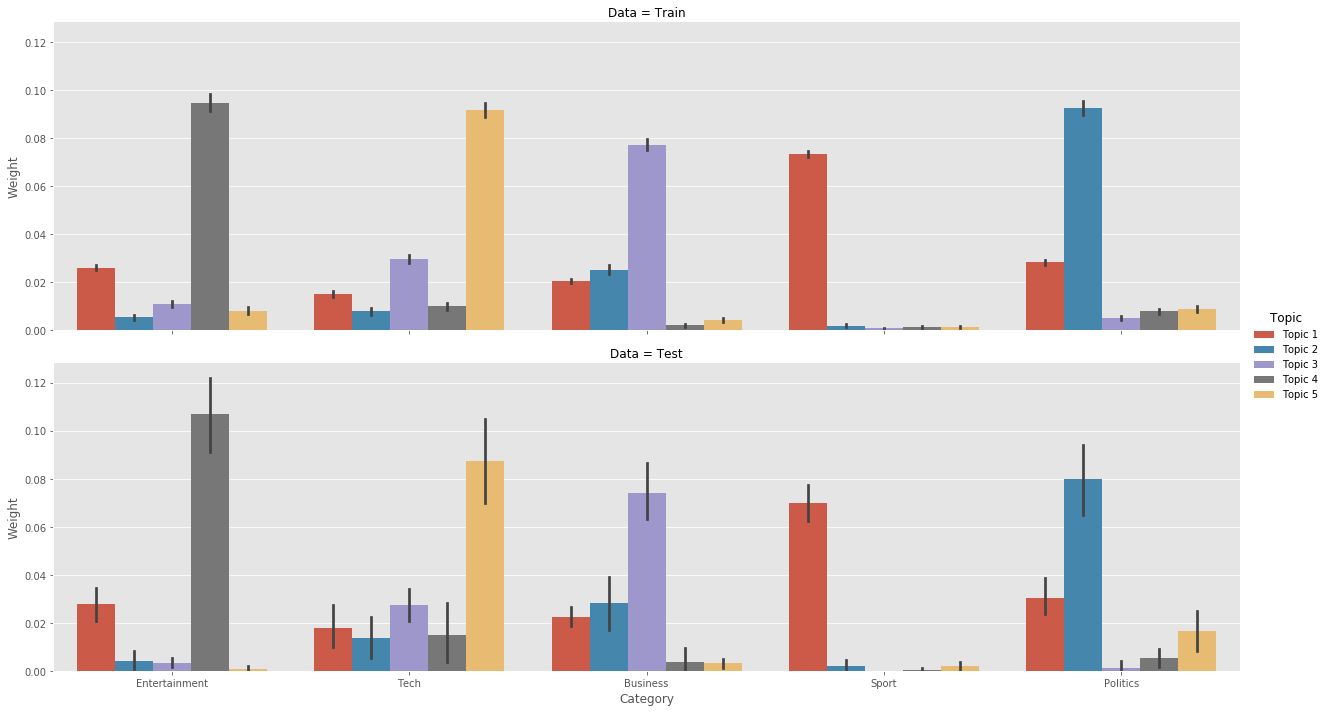

In [53]:
result = pd.melt(train_result.assign(Data='Train')
                 .append(test_eval.assign(Data='Test'))
                 .reset_index(),
                 id_vars=['Data', 'Category'],
                 var_name='Topic',
                 value_name='Weight')

result = pd.melt(train_result.assign(Data='Train')
                 .append(test_eval.assign(Data='Test'))
                 .reset_index(),
                 id_vars=['Data', 'Category'],
                 var_name='Topic',
                 value_name='Weight')

g =sns.catplot(x='Category', y='Weight', hue='Topic', row='Data', kind='bar', data=result, aspect=3.5)
g.savefig('plsa_train_test', dpi=300)


### Most important words by topic

In [57]:
topics = pd.DataFrame(nmf.components_.T,
                      index=tokens,
                      columns=topic_labels)
topics.loc[word_count.head(10).index]

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
film,0.00,0.00,0.01,0.41,0.00
game,0.35,0.00,0.00,0.00,0.02
best,0.27,0.00,0.00,0.25,0.00
labour,0.00,0.31,0.00,0.01,0.00
music,0.00,0.00,0.00,0.24,0.19
company,0.04,0.00,0.51,0.00,0.00
election,0.00,0.31,0.00,0.00,0.00
england,0.24,0.00,0.00,0.00,0.00
party,0.01,0.32,0.00,0.03,0.01
market,0.01,0.03,0.46,0.00,0.00


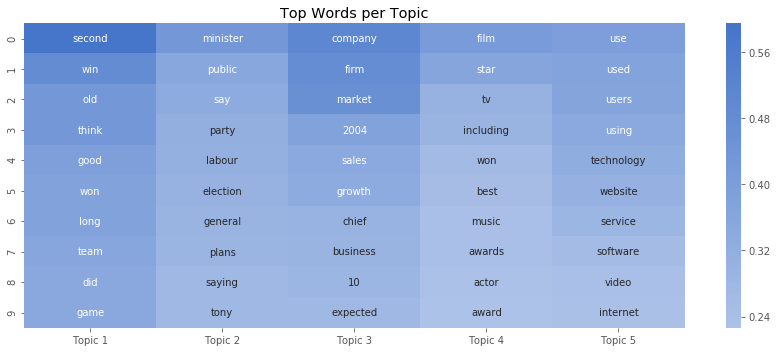

In [62]:
fig, ax = plt.subplots(figsize=(12,5))
top_words, top_vals = pd.DataFrame(), pd.DataFrame()
for topic, words_ in topics.items():
    top10 = words_.nlargest(10).index
    vals = words_.loc[top10].values
    top_vals[topic] = vals
    top_words[topic] = top10.tolist()
sns.heatmap(pd.DataFrame(top_vals), 
            annot=top_words, 
            fmt = '', 
            center=0, 
            cmap=sns.diverging_palette(0, 255, sep=1, n=256), 
            ax=ax);
ax.set_title('Top Words per Topic')
fig.tight_layout()
fig.savefig('plsa_top_words', dpi=300);

In [63]:
topics = pd.DataFrame(nmf.components_.T,
                      index=words,
                      columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
10,0.26,0.00,0.29,0.00,0.00
100,0.04,0.06,0.06,0.00,0.09
100m,0.04,0.00,0.00,0.00,0.00
11,0.08,0.00,0.10,0.11,0.00
12,0.13,0.00,0.17,0.00,0.00


In [64]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,second,minister,company,film,use
1,win,public,firm,star,used
2,old,say,market,tv,users
3,think,party,2004,including,using
4,good,labour,sales,won,technology
5,won,election,growth,best,website
6,long,general,chief,music,service
7,team,plans,business,awards,software
8,did,saying,10,actor,video
9,game,tony,expected,award,internet
